<a href="https://colab.research.google.com/github/LuisFdez91/Data-Science-PREWORK/blob/main/DEMANDA_EL%C3%89CTRICA_Series_Temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PREDICCIÓN DE LA DEMANDA ELÉCTRICA**

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales.

El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

In [ ]:
from PIL import Image
import requests

# Subir la imagen a colab
image_path1 = '/content/Image20230626110917.gif'

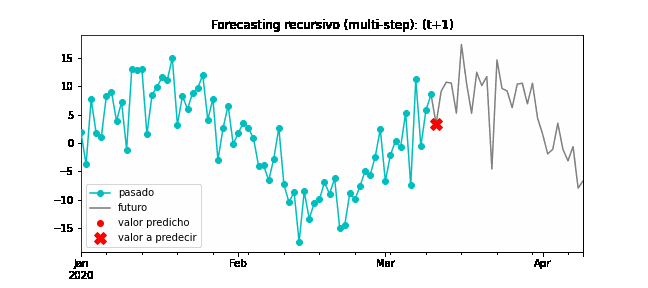

In [ ]:
# Cargar la imagen
image1 = Image.open(image_path1)
image1.show()

Cuando se trabaja con series temporales, raramente se quiere predecir sólo ek siguiente elemento de la serie t(n+1). Se trata de predecir los siguientes períodos en un intervalo de predicción t(n+1), ..., y(n+h), siendo h el horizonte o umbral de predicción. Existen varias formas de hacer dicha predicción, pero las dos más relevantes son las siguientes:
* **Forecasting recursive multi-step**: Dado que para predecir la observación t(n) se requiere de la información hasta t(n-1). Se aplica un proceso recursivo en el que cada nueva observación se basa en la información hasta el instante anterior. Este proceso se conoce como predicción recursiva o predicción multi-step.
* **Forecasting direct multi-step**: este modelo consiste en entrenar un modelo diferente para cada valor futuro (step) del horizonte de predicción (h). Por ejemplo: para predecir los 5 valores siguientes de una serie temporal, se entrenan 5 modelos diferentes, uno para cada _step_ de este modo, las predicciones son independientes entre sí.

## **Muestra (Sample)**

Los datos empleados se corresponden al documento incluido en tsibbledata de R-. El dataframe contiene datos de 5 columnas con 52608 registros.

* **Time**: fecha y hora del registro.
* **Date**: fecha del registro.
* **Demand**: demanda de electricidad en MW
* **Temperature**: temperatura registrada en dicha fecha.
* **Holiday**: indiciador de si el día es festivo (variable dummy que toma valor 1 si el día es festivo y 0 en cualquier otro caso).

In [ ]:
pip install skforecast # instalamos skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0


In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Descarga de datos
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
datos = pd.read_csv(url, sep=',')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [ ]:
datos

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


La columna _Time_ se ha almacenado como string (object).
Debemos convertirla en datatime. Una vez en formato "datetime" se establecerá como **índice**.

Además, dado que los datos tienen intervalos de registro de frecuencia 30 mins, se indicará esta frecuencia ('30 mins').

In [ ]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ') # datetime
datos = datos.set_index('Time') # indexación
datos = datos.asfreq('30min') # intervalos de 30min
datos = datos.sort_index() # ordenación de menor a mayor por date
datos.head(2) # comprobamos dos filas de datos

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


La indexación y creación del date time es correcto.

El siguiente paso del análisis es realizar una comprobación mediante una prueba lógica de que la serie temporal es completa (no faltan datos).

In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

Al resolver un "True" indica que la serie temporal es completa.

In [ ]:
# Missing Values
#==============================================================================
print(f"Filas con missing values: {datos.isnull().any(axis=1).mean()}")

Filas con missing values: 0.0


No tenemos valores ausentes.

In [ ]:
#¿Que haríamos si tenemos datos NaN en este caso?
# datos.asfreq(freq='30min', fill_value=np.nan)  NO LO EJECUTAMOS AL NO SER NECESARIO AHORA

Aunque los datos se encuentran en intervalos de tiempo de 30 minutos, el objetivo es crear un modelo capaz de predecir la demanda eléctrica **a nivel horario**, por lo que se tienen que agregar los datos a esta frecuencia. Este tipo de transformación se hace por el método **resample()** de Pandas.

Se deben escoger muy bien los argumentos closed='left' y label='right para no introducir en el entrenamiento información a futuro (leakage).

In [ ]:
# Veamos un ejemplo:
#==============================================================================
from PIL import Image
import requests

# Subir la imagen a colab
image_path2 = '/content/diagram_resampling_datetime.png'# Aquín pon tu ruta del archivo

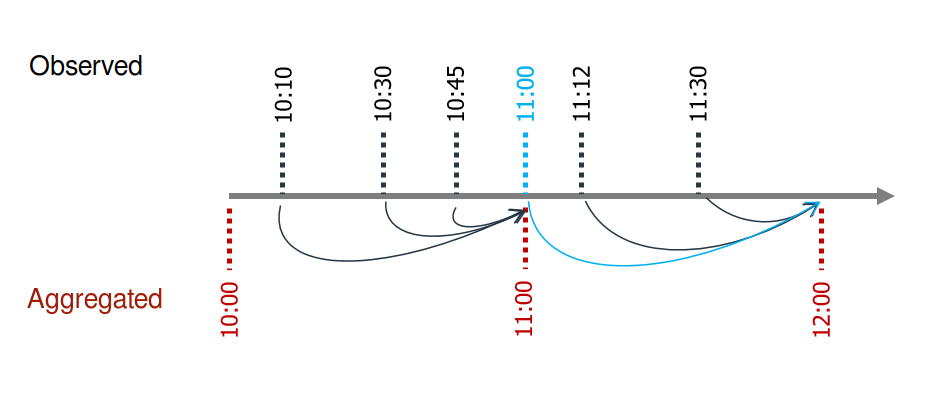

In [ ]:
# Cargar la imagen
image2 = Image.open(image_path2)
image2.show()

Todas las observaciones anteriores entre las 10:00 y las 11:00 se convertirán en el promedio para esta fecha.

Las observaciones desde las 11 a las 12 serán el promedio de las 12:00.

Y así sucesivamente...

In [ ]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

KeyError: ignored

Como se deprende de la tabla anterior disponemos de la demanda media y temperatura promedio por hora.

In [ ]:
datos.tail(10)

,Demand,Temperature,Holiday
Time,,,
2014-12-31 04:00:00,4014.137428,22.60,0.0
2014-12-31 05:00:00,4085.009663,22.80,0.0
2014-12-31 06:00:00,4245.089081,23.25,0.0
2014-12-31 07:00:00,4377.558236,25.15,0.0
2014-12-31 08:00:00,4273.377941,23.65,0.0
2014-12-31 09:00:00,4069.625550,21.60,0.0
2014-12-31 10:00:00,3909.230704,20.30,0.0
2014-12-31 11:00:00,3900.600901,19.65,0.0
2014-12-31 12:00:00,3758.236494,18.10,0.0


Esto son las últimas 10 observaciones. Con sólo el objetivo de comprobar que la variable dummy Holiday presenta ceros y unos.

In [ ]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


La muestra de entrenamiento abarca de 2012-01-01 a 2013-12-31 (n=17544 datos), la muestra de validación del modelo abarca de 2014-01-01 a 2014-11-30 (n=8016 datos) y por último, la muestra de test abarca de 2014-12-01 a 2014-12-30 (n=720).

## **EXPLORAICÓN GRÁFICA**

Cuando se tienen series temproales y se desea generar un modelo en base a ellas se debe realizar el plot de la serie temporal, para así determinar la presencia de tendencias y estacionalidad en las series.



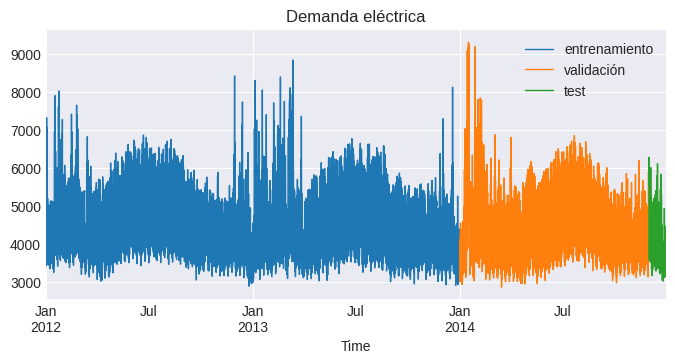

In [ ]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Crea una figura interactiva
fig = go.Figure()

# Agrega las líneas de datos a la figura
fig.add_trace(go.Scatter(x=datos_train.index, y=datos_train.Demand, name='entrenamiento', line=dict(width=1)))
fig.add_trace(go.Scatter(x=datos_val.index, y=datos_val.Demand, name='validación', line=dict(width=1)))
fig.add_trace(go.Scatter(x=datos_test.index, y=datos_test.Demand, name='test', line=dict(width=1)))

# Ajusta el diseño de la figura
fig.update_layout(title='Demanda eléctrica')

# Muestra la figura interactiva
fig.show()

Se detecta un comportamiento estacional prueba de ello es que en todos los meses de enero (January) existe un punto o exceso de demanda eléctrica al igual que en julio (July) menos intenso que la demanda de los meses dde enero.

Esto es debido al consumo de calefacción en los meses de invierno y al aire acondicionado en los meses de verano. Se confirma patrines estacionales lo que permitiría aplicar metodologías de series temporales de tipo ARIMA.

Al hacer zoom a la serie temporal mediante el gráfico interactivo, se puede evidenciar aún más si cabe el comportamiento estacional de la demanda eléctrica.

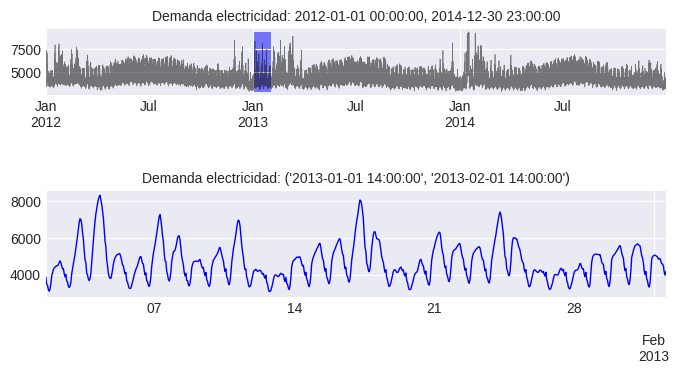

In [ ]:
# Gráfico serie temporal con zoom si no tenemos el gráfico interactivo
# ==============================================================================
zoom = ('2013-01-01 14:00:00','2013-02-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

Al establecer un zoom para sólo el mes de enero se observa además una estacionalidad diaria.

### **Estacionalidad anual, semanal y diaria**

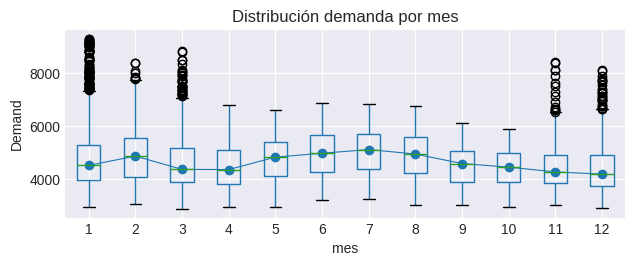

In [ ]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

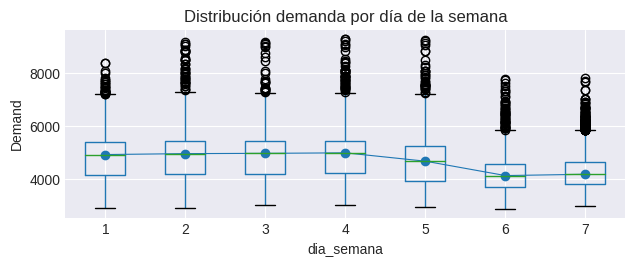

In [ ]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

Se aprecia una estacionalidad semanal, con valores de demanda inferiores durante el fin de semana.

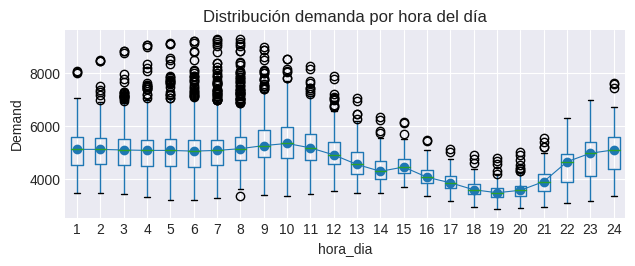

In [ ]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas.

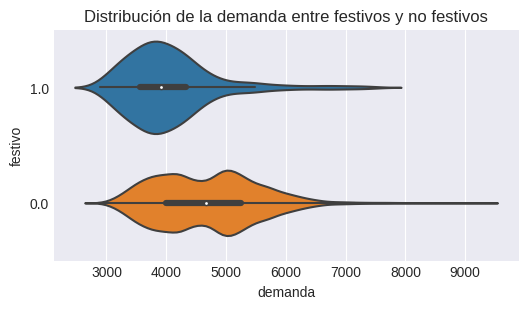

In [ ]:
# Días festivos y no festivos ¿Hay cambios significativos en la demanda eléctrica?
#=================================================================================
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

Se puede apreciar que el violin plot de los días no festivos (0) toma valores predominantes entre 3000-6500.

Mientras que el gráfico violin plot de los días festivos tan sólo concentra la demanda para valores entre 3000 y 5500.

Existe una menor demanda en los días festivos que el resto de días.

### **Gráficos de autocorrelación**

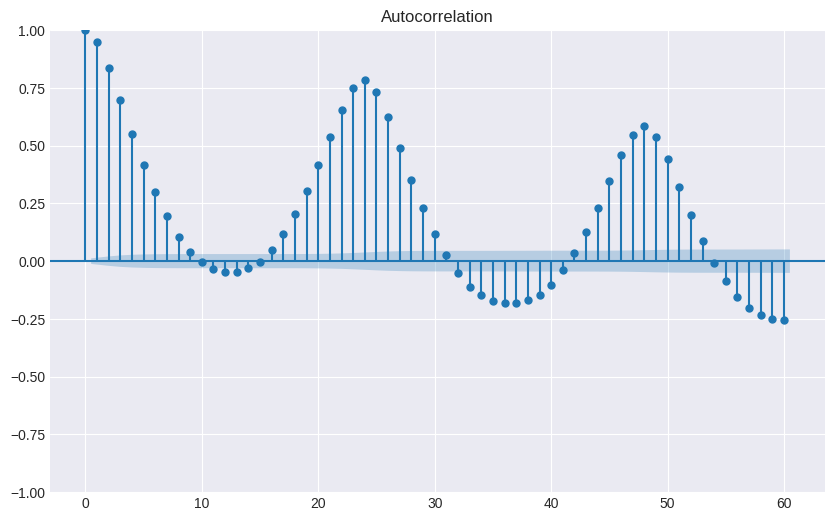

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show()

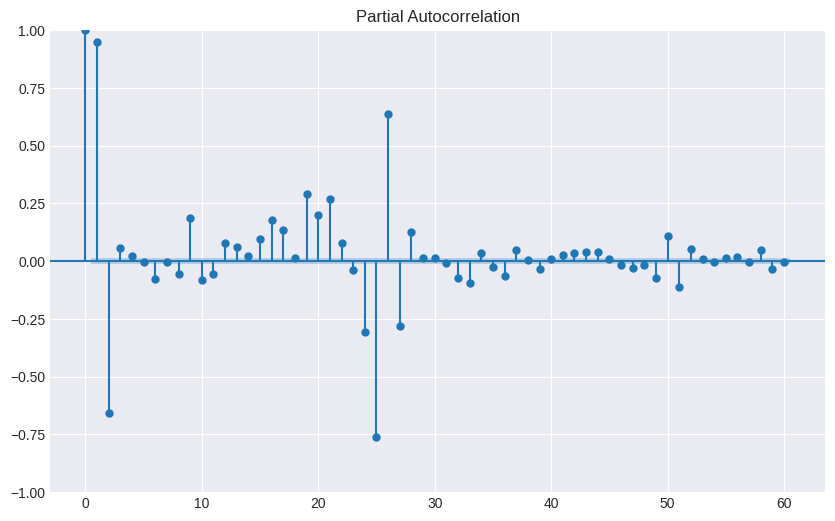

In [ ]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show()

La función de autocorrelación simple (ACF) muestra autocorrelaciones estadísticamente significativas en intervalos de 24H. A su vez, la autocorrelación parcial encuentra valores significativos cada 24 horas. Todo lo anterior confirma la dependencia en intervalos diarios (cada 24 horas).

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre la demanda de una hora y las horas anteriores, así como entre la demanda de una hora y la demanda de esa misma hora los días anteriores. Este tipo de correlación es un indicativo de que los modelos autorregresivos pueden funcionar bien.

## **MODELO AUTORREGRESIVO PREDICTIVO**

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-06-26 10:09:03 
Last fit date: 2023-06-26 10:09:03 
Skforecast version: 0.8.1 
Python version: 3.10.12 
Forecaster id: None 

## **Predicción y backtest**

Se evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2012-01-01 00:00 al 2014-11-30 23:59 y, después, a las 23:59 de cada día, se predijesen las 24 horas siguientes. A este tipo de evaluación se le conoce como backtesting

In [ ]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            refit              = False,
                            verbose            = True,
                            show_progress      = True
                        )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

  0%|          | 0/30 [00:00<?, ?it/s]

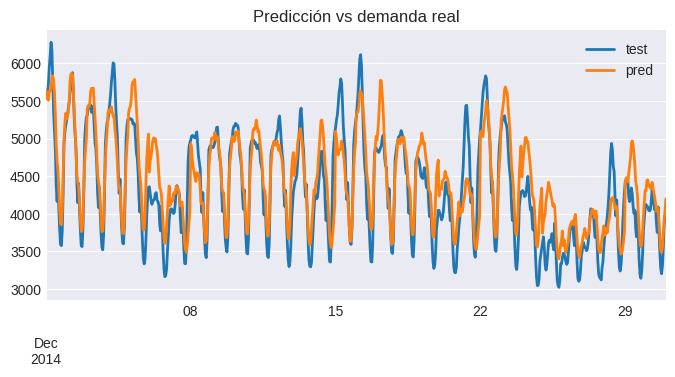

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 289.5191331582498


El modelo funciona correctamente, pero debemos optimizar el modelo con el gridsearch de hiperparámetros.

## **Optimización de hiperpaerámetros (tuning)**

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un Grid Search. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante backtesting. En el proceso de búsqueda, es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan sólo en último lugar para evaluar al modelo final.


In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24, # Este valor será remplazado en el grid search
                 transformer_y = StandardScaler()
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = datos.loc[:fin_validacion, 'Demand'],
                      steps              = 24,
                      metric             = 'mean_absolute_error',
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      initial_train_size = len(datos[:fin_train]),
                      refit              = False,
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.84309845082885



El error antes del tuning fue = **289.51**
El error después del tuning es = **257.84**

El modelo ha mejorado, gracias al tuning de hiperparámetros.

In [ ]:
# Resultados Grid Search
# ====================================
resultados_grid

,lags,params,mean_absolute_error,alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 215.44346900318823},257.843098,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},290.527024,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},306.626903,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},309.392653,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},309.775993,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},309.825950,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},309.832409,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},325.041130,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},325.043580,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},325.062545,0.059948


El modelo se optimiza con [1,2,3,23,24,25,47,48,49] y un alfa de 215,44 que minimiza el RMSE en un 257,84

In [ ]:
# Entrenamiento del mejor modelo obtenido:
#===============================================
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-06-26 10:19:32 
Last fit date: 2023-06-26 10:20:58 
Skforecast version: 0.8.1 
Python version: 3.10.12 
Forecaster id: None 

## **Backtest con la muestra del test (después de entrenar)**

  0%|          | 0/30 [00:00<?, ?it/s]

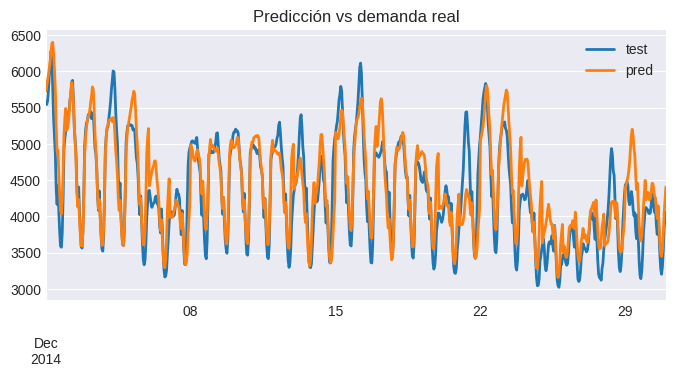

In [ ]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = mean_absolute_error,
                            initial_train_size = len(datos[:fin_validacion]),
                            refit              = False,
                            verbose            = False,
                            show_progress      = True
                        )

fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

Este modelo obtiene predicciones mucho más ajustadas que el modelo previo al tuning de hiperparámetros.

In [ ]:
# Error backtest
# ===============================
print(f'Error backtest: {metrica}')

Error backtest: 251.92726486972396


Tras la optimización de lags e hiperparámetros, se ha conseguido reducir el error de predicción de 289.5 a 251.9

Un intervalo de predicción define el intervalo dentro del cuál es de esperar que se encuentre el verdadero valor de  y
  con una determinada probabilidad. Por ejemplo: es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

In [ ]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos['Demand'],
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            initial_train_size  = len(datos.loc[:fin_validacion]),
                            refit               = False,
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False,
                            show_progress       = True
                        )

print('Métrica backtesting:', metrica)
predicciones.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

Métrica backtesting: 251.92726486972396


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.844947,5598.931844,5849.598860
2014-12-01 01:00:00,5802.807448,5599.126464,5974.887546
2014-12-01 02:00:00,5879.948808,5619.868497,6113.714851
2014-12-01 03:00:00,5953.414468,5657.436246,6239.937101
2014-12-01 04:00:00,6048.594433,5697.672143,6342.846047


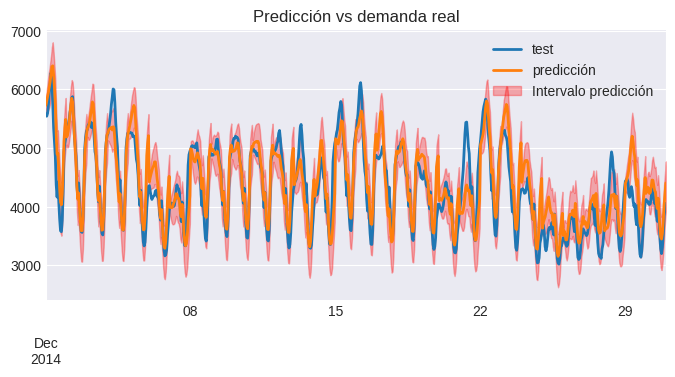

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción'
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                       (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                       (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                       True,
                       False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 79.03 %


El intervalo predicho tiene una cobertura inferior a la que cabría esperar (80%). Esto puede deberse al error marcadamente elevado que
comete el modelo para los dias 21, 24 y 25.

Estos días están dentro del periodo vacacional de navidad, que suele caracterizarse por un comportamiento de consumo distinto al resto del
mes.

## **Predicción diaria anticipada**

En el apartado anterior, se evalud el modelo asumiendo que las predicciones del dia siguiente se ejecutan justo al final del dia anterior. En la
practica, esto no resulta muy util ya que, para las primeras horas del dia, apenas se dispone de anticipacion.

Supongase ahora que, para poder tener suficiente margen de accion, a las 11:00 horas de cada dia se tienen que generar las predicciones
del dia siguiente. Es decir, a las 11:00 del dia *D* se tienen que predecir las horas [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] de ese mismo
dia, y las horas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] del día *D+1*. Esto implica que se tienen que predecir
un total de 36 horas a futuro aunque solo se almacenen las 24 últimas.

El proceso adaptado a este escenario se ejecuta diariamente y consta de los siguientes pasos:

A las 11:00h del primer día del conjunto de test, se predicen las 36 horas siguientes (las 12 horas que quedan del día más las 24 horas del día siguiente).

Se almacenan solo las predicciones del día siguiente, es decir, las 24 últimas.

Se añaden los datos de test hasta las 11:00 del día siguiente.

Se repite el proceso.

De esta forma, a las 11:00 de cada día, el modelo tiene acceso a los valores reales de demanda registrados hasta ese momento.

In [ ]:
# Final de initial_train_size + 12 posiciones
# ==============================================================================
datos.iloc[:len(datos.loc[:fin_validacion])+12].tail(2)

,Demand,Temperature,Holiday,mes,dia_semana,hora_dia
Time,,,,,,
2014-12-01 10:00:00,5084.011257,19.90,0.0,12,1,11
2014-12-01 11:00:00,4851.066658,19.35,0.0,12,1,12


In [ ]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            verbose               = True,
                            show_progress         = True
                        )

print("")
print('Métrica backtesting:', metrica)
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25572
Number of observations used for backtesting: 708
    Number of folds: 29
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-0

  0%|          | 0/29 [00:00<?, ?it/s]


Métrica backtesting: 374.33731759267727


,pred
2014-12-02 00:00:00,5154.952086
2014-12-02 01:00:00,5183.487126
2014-12-02 02:00:00,5263.237055
2014-12-02 03:00:00,5397.278836
2014-12-02 04:00:00,5571.542647


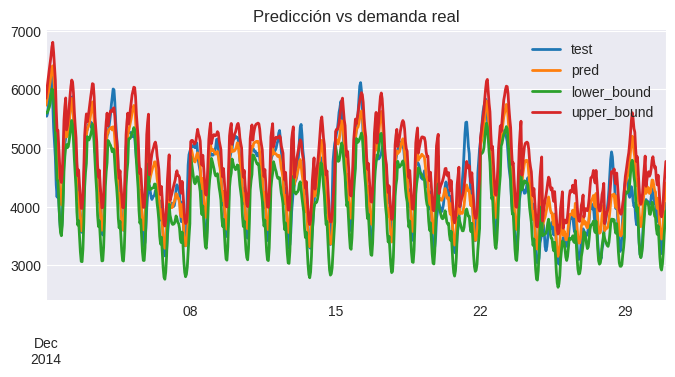

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

Como es lógico, el horizonte de predicción también aumenta el error.

## **Importancia de predictores**

In [ ]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importances()

,feature,importance
0,lag_1,1.027185
1,lag_2,-0.017558
2,lag_3,-0.072357
3,lag_23,0.145979
4,lag_24,0.351853
5,lag_25,-0.471072
6,lag_47,-0.057676
7,lag_48,0.284220
8,lag_49,-0.217552


En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable objetivo. En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y que pueden servir como predictores adicionales en el modelo. Algunos ejemplos típicos son:

Festivos (local, nacional...)

Mes del año

Día de la semana

Hora del día

En este caso de uso, el análisis gráfico mostraba evidencias de que, los días festivos, la demanda es menor. Si un día es festivo o no, puede saberse a futuro, por lo que se puede emplear como variable exógena

## **Entrenamiento del Forecaster**

In [ ]:
# Se convierte la columna Holiday de boolean a integer
# ==============================================================================
datos['Holiday'] = datos['Holiday'].astype(int)
datos_train['Holiday'] = datos_train['Holiday'].astype(int)
datos_test['Holiday'] = datos_test['Holiday'].astype(int)

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(alpha=215.44, random_state=123),
                 lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, 'Holiday'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-06-26 10:45:01 
Last fit date: 2023-06-26 10:45:01 
Skforecast version: 0.8.1 
Python version: 3.10.12 
Forecaster id: None 

## **Predicción diaria anticipada**

In [ ]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos['Holiday'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            verbose               = False,
                            show_progress         = True
                        )

  0%|          | 0/29 [00:00<?, ?it/s]

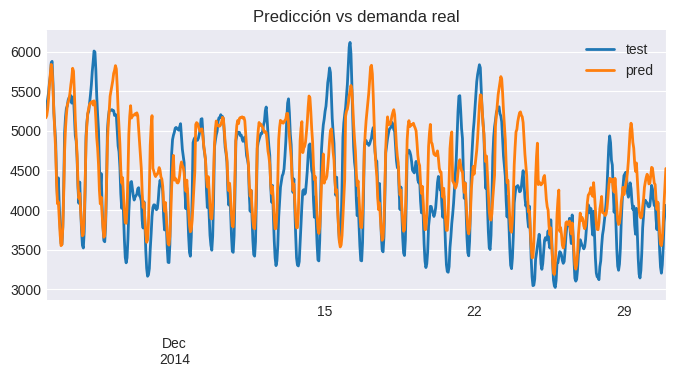

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 359.10771907713166


Utilizando como variable exógena si el día es festivo o no, se consigue reducir ligeramente el error de predicción de 373.5 a 359.1. Véase qué ocurre al añadir si el día anterior y siguiente son festivos, el día de la semana y hora del día

In [ ]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos['Holiday_day_before'] = datos['Holiday'].shift(24)
datos['Holiday_next_day']   = datos['Holiday'].shift(-24)
datos = datos.dropna()

# One hot encoding del día de la semana y la hora del día
# ==============================================================================
one_hot_encoder = make_column_transformer(
                        (
                            OneHotEncoder(sparse_output=False, drop='if_binary'),
                            ['dia_semana', 'hora_dia'],
                        ),
                        remainder="passthrough",
                        verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

datos = one_hot_encoder.fit_transform(datos)
datos.head(3)

,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7,hora_dia_1,hora_dia_2,hora_dia_3,...,hora_dia_21,hora_dia_22,hora_dia_23,hora_dia_24,Demand,Temperature,Holiday,mes,Holiday_day_before,Holiday_next_day
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5262.895338,32.825,1,1,1.0,0.0
2012-01-02 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5786.043417,34.500,1,1,1.0,0.0
2012-01-02 02:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,6236.144167,36.725,1,1,1.0,0.0


In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44, random_state=123),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Holiday'))]
forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, exog])

# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos[exog],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            verbose               = False,
                            show_progress         = True
                        )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print("")
print(f"Error de backtest: {error}")

  0%|          | 0/28 [00:00<?, ?it/s]


Error de backtest: 298.61178509202466


El error de test ha mejorado, pues ahora es **298.61**

## **Incluir la temperatura como variable exógena**

Dado que en el set de datos también se dispone de la temperatura, y esta está relacionada con la demanda, podría ser tentador incorporarla como predictor. Sin embargo, esta aproximación no sería correcta ya que, la temperatura no se conoce a futuro. Sí es posible utilizar la previsión de tempratura como un predictor del modelo pero, en tal caso, durante el entrenamiento habría que utilizar la previsión que había en ese momento, no la temperatura real.

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor        = LGBMRegressor(random_state=123),
                 steps            = 36, # Steps + gap
                 lags             = 24, # Este valor será remplazado en el grid search
                 transformer_y    = None,
                 transformer_exog = None
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                      forecaster            = forecaster,
                      y                     = datos.loc[:fin_validacion, 'Demand'],
                      exog                  = datos.loc[:fin_validacion, exog],
                      steps                 = 24,
                      metric                = 'mean_absolute_error',
                      param_grid            = param_grid,
                      lags_grid             = lags_grid,
                      initial_train_size    = len(datos.loc[:fin_train])+12,
                      gap                   = 12,
                      allow_incomplete_fold = True,
                      refit                 = False,
                      return_best           = True,
                      verbose               = False
                  )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'max_depth': 6, 'n_estimators': 500}
  Backtesting metric: 243.65601976494384



In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_absolute_error,max_depth,n_estimators
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 500}",243.656020,6,500
3,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 500}",246.156925,6,500
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 500}",251.087154,4,500
1,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 500}",254.086127,4,500
2,"[1, 2, 3, 23, 24]","{'max_depth': 6, 'n_estimators': 100}",272.986569,6,100
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 6, 'n_estimators': 100}",273.278625,6,100
0,"[1, 2, 3, 23, 24]","{'max_depth': 4, 'n_estimators': 100}",307.270799,4,100
4,"[1, 2, 3, 23, 24, 25, 47, 48, 49]","{'max_depth': 4, 'n_estimators': 100}",307.566413,4,100


  0%|          | 0/28 [00:00<?, ?it/s]

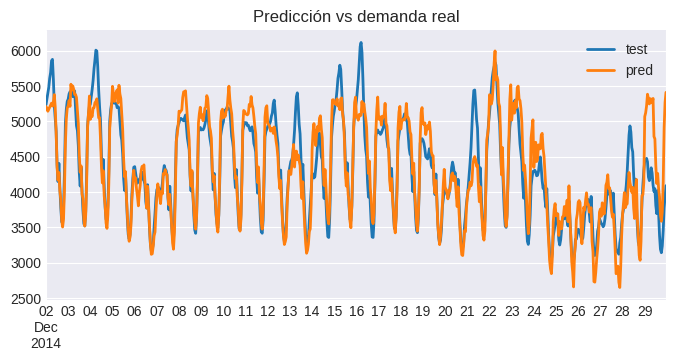

In [ ]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos[exog],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            verbose               = False,
                            show_progress         = True
                        )
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [ ]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 222.42852414702134


En este caso, empleando un modelo Gradient Boosting (LGBMRegressor), la estrategia direct multi-step genera mejores resultados que la estrategia recursiva con un modelo lineal.

In [ ]:
pip install session_info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.6 MB/s eta 0:00:00
  Created wheel for session_info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=18ccb0191a6ec0195876eefb5546e9402747150db6a32920b419c38bd1c3960e
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session_info


In [ ]:
# informe de la sesión
#==============================================================================
import session_info
session_info.show(html=True)